# FIG. 4. Simulation of the traffic conditions in the Ahr valley.

In [1]:
import networkx as nx
import osmnx as ox
import numpy as np
import geopandas as gpd
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colors

import cartopy.crs as ccrs

crs = ccrs.GOOGLE_MERCATOR
import warnings

fontsize = 20

pgf_with_latex = {  # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",  # change this if using xetex or lautex
    "text.usetex": True,  # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],  # blank entries should cause plots
    "font.sans-serif": [],  # to inherit fonts from the document
    "font.monospace": [],
    "axes.labelsize": fontsize,  # LaTeX default is 10pt font.
    "font.size": fontsize,
    "legend.fontsize": fontsize,  # Make the legend/label fonts
    "xtick.labelsize": fontsize,  # a little smaller
    "ytick.labelsize": fontsize,
    "figure.figsize": (16, 12),  # default fig size of 0.9 textwidth
    "pgf.preamble": "\n".join(
        [  # plots will use this preamble
            r"\usepackage[utf8]{inputenc}",
            r"\usepackage[T1]{fontenc}",
        ]
    ),
}
mpl.rcParams.update(pgf_with_latex)


import src.RoadNetwork as rn
import src.TrafficCentrality as tc
import src.GermanMobiltyPanel as gmp
import src.FloodModule as fm


# Create RoadNetwork from bbox

In [2]:
west, east = 6.65, 7.4
south, north = 50.25, 50.75

driving_tags = [
    "motorway",
    "motorway_link",
    "trunk",
    "trunk_link",
    "primary",
    "primary_link",
    "secondary",
    "secondary_link",
    "tertiary",
    "tertiary_link",
    "unclassified",
    "residential",
]
highway_filter = f"w/highway={','.join(driving_tags)}"

region = rn.RoadNetwork(
    osmpbf="germany.osm.pbf",
    highway_filter=highway_filter,
    bbox=[north, south, west, east],
)
G = region.graph


num(nodes)= 32253
num(edges)= 76950


### Compute the load of every edge (spatial incoporated betweenness centrality) and compute the effective velocities with an occpuation of $\gamma=0.15$. We provide the cached results. You can set "cache=False" to the loads function to compute the values locally, but that will take a  while depending on your system. Setting cpu_cores=N will use a parallel version of the method.

In [3]:
region.loads("travel_time")
region.effective_velocities(0.15)

nodes, edges = ox.graph_to_gdfs(region.graph)


The SIBC has already been computed and stored. Providing the stored values.


/Users/jonas/resilience-of-transportation-infrastructure-networks-to-road-failures/src/EffectiveVelocities.py:263: RuntimeWarning: divide by zero encountered in scalar divide
  e: (lengths[e] * lanes_mod[e] / (peak_loads[e] * t_react) - x_veh / t_react)


### Projecting the GDFs to the right CRS as well as splitting up the edges into different categories depending on the OSM tag.

In [4]:
crs_proj4 = crs.proj4_init
proj_edges = region.edges.to_crs(crs_proj4)

prim = ["motorway", "trunk", "primary", "motorway_link", "trunk_link", "primary_link"]
prim_edg = proj_edges[proj_edges["highway"].apply(lambda x: x in prim)]
sec = ["secondary", "secondary_link"]
sec_edg = proj_edges[proj_edges["highway"].apply(lambda x: x in sec)]
tert = ["tertiary", "tertiary_link"]
tert_edg = proj_edges[proj_edges["highway"].apply(lambda x: x in tert)]


### Build the Figure

Text(0, 0.5, '$1 - v_{\\mathrm{eff}}/v_{\\mathrm{limit}} (ij)$')

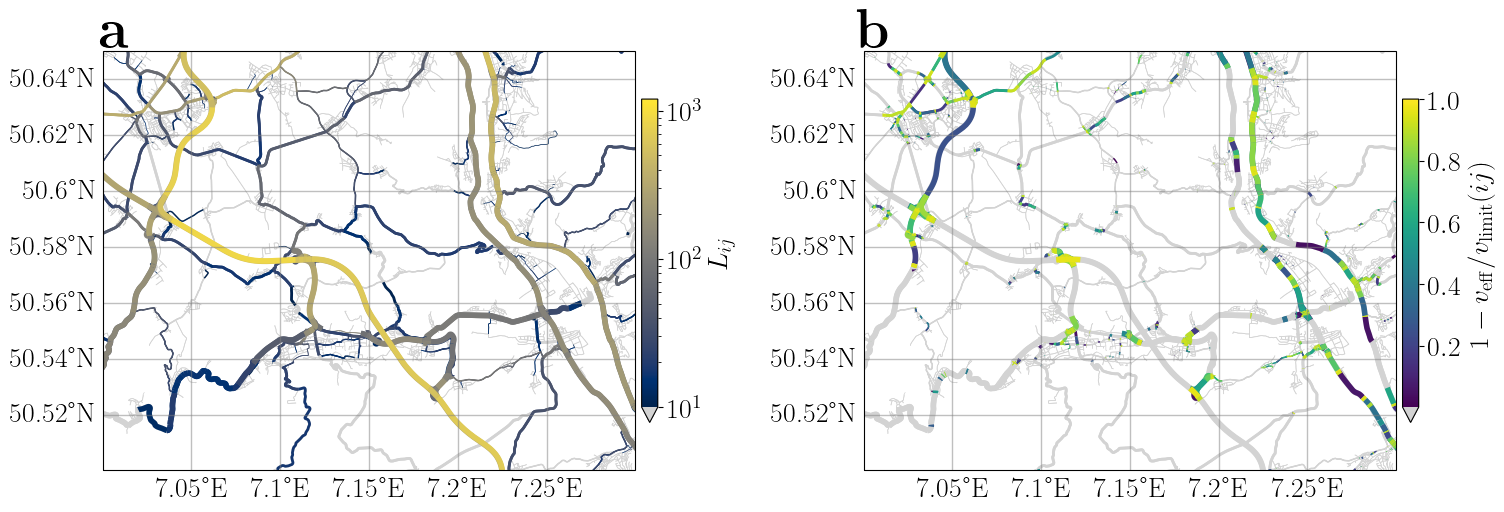

In [5]:
warnings.filterwarnings("ignore")

fig, axs = plt.subplots(1, 2, figsize=(18, 6), subplot_kw={"projection": crs})
for ax in axs:
    ax.set_extent([7, 7.3, 50.5, 50.65], crs=ccrs.PlateCarree())
    ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels={"bottom": "x", "left": "y"},
        linewidth=1,
        color="gray",
        alpha=0.5,
        linestyle="-",
    )
axs[0].text(
    0.05,
    1.1,
    r"\textbf{a}",
    transform=axs[0].transAxes,
    fontweight="bold",
    fontsize=40,
    va="top",
    ha="right",
)

axs[1].text(
    0.05,
    1.1,
    r"\textbf{b}",
    transform=axs[1].transAxes,
    fontweight="bold",
    fontsize=40,
    va="top",
    ha="right",
)

######################################################################
data = proj_edges["load"]

cmap = plt.get_cmap("cividis")
cmap.set_under("lightgrey")
norm = mpl.colors.LogNorm(vmin=1e1, vmax=max(edges["load"]))
scalar_mapper = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

proj_edges.loc[(proj_edges["load"] == 0), "load"] = 1
proj_edges.sort_values(by="load").plot(
    column="load",
    ax=axs[0],
    zorder=0,
    cmap=cmap,
    norm=norm,
    linewidth=0.5,
    # legend_kwds={"label": r"$L_{ij}$", "extend": "min"},
)
tert_edg.sort_values(by="load").plot(
    data[tert_edg.index], ax=axs[0], linewidth=1, zorder=0, cmap=cmap, norm=norm
)
sec_edg.sort_values(by="load").plot(
    data[sec_edg.index], ax=axs[0], linewidth=2, zorder=0, cmap=cmap, norm=norm
)
prim_edg.sort_values(by="load").plot(
    data[prim_edg.index], ax=axs[0], linewidth=4, zorder=0, cmap=cmap, norm=norm
)
cbar = fig.colorbar(scalar_mapper, ax=axs[0], shrink=0.7, extend="min", pad=0.01)
cbar.ax.set_ylabel(r"$L_{ij}$")

######################################################################


cmap = plt.get_cmap("viridis")
cmap.set_under("lightgrey")

# bounds = np.linspace(1e-5, 1, 11)
norm = mpl.colors.Normalize(vmin=1e-3, vmax=1)
scalar_mapper = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

data = 1 - edges["effective_velocity"] / edges["speed_kph"]
proj_edges["data"] = data
tert_edg["data"] = data
sec_edg["data"] = data
prim_edg["data"] = data


proj_edges.sort_values(by="data").plot(
    data,
    ax=axs[1],
    zorder=0,
    cmap=cmap,
    norm=norm,
    # legend=True,
    linewidth=0.5,
    # legend_kwds={"label": r"$1 - v_{\mathrm{eff}}/v_{\mathrm{limit}} (ij)$"},
)
tert_edg.sort_values(by="data").plot(
    data[tert_edg.index],
    ax=axs[1],
    linewidth=1,
    zorder=0,
    cmap=cmap,
    norm=norm,
)
sec_edg.sort_values(by="data").plot(
    data[sec_edg.index], ax=axs[1], linewidth=2, zorder=0, cmap=cmap, norm=norm
)
prim_edg.sort_values(by="data").plot(
    data[prim_edg.index],
    ax=axs[1],
    linewidth=4,
    zorder=0,
    cmap=cmap,
    norm=norm,
)

cbar = fig.colorbar(scalar_mapper, ax=axs[1], shrink=0.7, extend="min", pad=0.01)
cbar.ax.set_ylabel(r"$1 - v_{\mathrm{eff}}/v_{\mathrm{limit}} (ij)$")


In [6]:
fig.savefig("results/figs/FIG4-Traffic-simulation.pdf", bbox_inches="tight")
